# Chapter 29
## Analyzing Neural Time Series, Mike X Cohen


#### imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from os.path import join as pjoin
from scipy import stats
import matplotlib.gridspec as gridspec
from pathlib import Path
import mne
from mne.externals.pymatreader import read_mat

## Reproduce figures

### Figure 29.2

[Text(0, 0.5, 'amplitude'), Text(0.5, 1.0, 'Sorted signal values')]

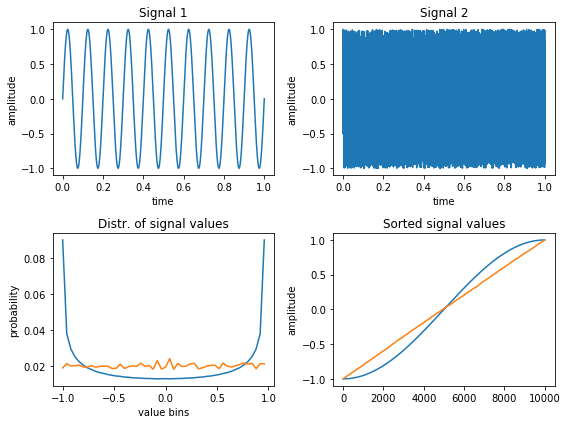

In [2]:
# create two signals
time = np.linspace(0,1,10000)
sig_1 = np.sin(2*np.pi*10*time)
sig_2 = np.random.rand(len(time)) * 2 - 1

# create figure
fig_29_2, ax = plt.subplots(2,2, figsize=[8,6], tight_layout=True)
((ax_1,ax_2), (ax_3,ax_4)) = ax

# plot signals (29.2 A and B)
ax_1.plot(time, sig_1)
ax_2.plot(time, sig_2)
ax_1.set(xlabel='time', ylabel='amplitude', title='Signal 1')
ax_2.set(xlabel='time', ylabel='amplitude', title='Signal 2')

# bin the data using histogram function
n_bins = 50
hist_1 = np.histogram(sig_1, n_bins)
hist_2 = np.histogram(sig_2, n_bins)

# convert histograms to probability values
prob_1 = hist_1[0] / np.sum(hist_1[0])
prob_2 = hist_2[0] / np.sum(hist_2[0])

# plot probabilities (29.2 C)
ax_3.plot(hist_1[1][:-1], prob_1)
ax_3.plot(hist_2[1][:-1], prob_2)
ax_3.set(xlabel='value bins', ylabel='probability', 
         title='Distr. of signal values')

# plot sorted values (29.2 D)
ax_4.plot(np.sort(sig_1))
ax_4.plot(np.sort(sig_2))
ax_4.set(ylabel='amplitude', title='Sorted signal values')


### Figure 29.3

[Text(0, 0.5, 'entropy'), Text(0.5, 0, 'number of bins')]

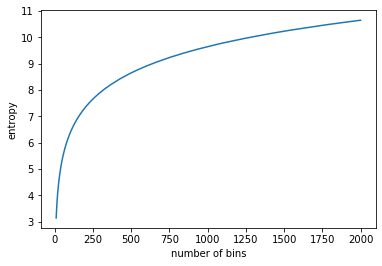

In [3]:
# define range of bin numbers
n_bins = np.arange(10,2000,1)

# initialize array
entropy = np.zeros(len(n_bins))

# bin data for each value of nbins and compute the entropy
for ii, nb in enumerate(n_bins):
    # bin data and compute probability
    hist = np.histogram(sig_1, nb)
    prob = hist[0] / np.sum(hist[0])
    
    # adjust probability to ensure non-zero
    prob += 1E-6
    
    # compute entropy
    entropy[ii] = -np.sum(prob * np.log2(prob))
    
# plot
fig_29_3, ax = plt.subplots()
ax.plot(n_bins, entropy)
ax.set(xlabel='number of bins', ylabel='entropy')

### Figure 29.4

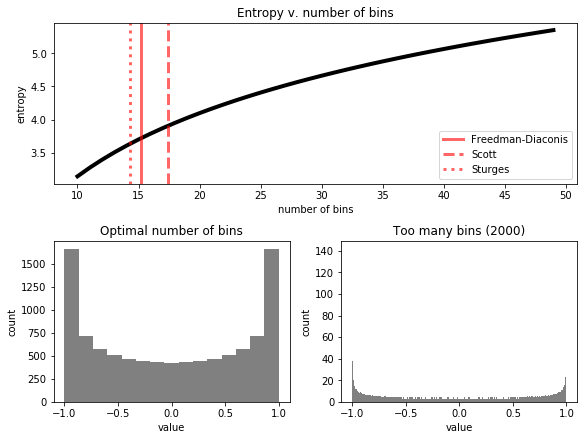

In [4]:
# calc sig params
n_samples = len(sig_1)
maxmin_range = np.max(sig_1) - np.min(sig_1)

# compute optimal bin number for various methods
fd_bins      = maxmin_range/(2.0*stats.iqr(sig_1)*n_samples**(-1/3)) # Freedman-Diaconis 
scott_bins   = maxmin_range/(3.5*np.std(sig_1)*n_samples**(-1/3)) # Scott
sturges_bins = 1+np.log2(n_samples) # Sturges

# create figure
fig_29_4 = plt.figure(figsize=[8,6], constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig_29_4)
ax_a = fig_29_4.add_subplot(spec[0, :])
ax_b = fig_29_4.add_subplot(spec[1, 0])
ax_c = fig_29_4.add_subplot(spec[1, 1])

# plot (29.2 A)
max_idx = np.argmin(abs(n_bins-50))
ax_a.plot(n_bins[:max_idx], entropy[:max_idx], linewidth=4, color='k')
ax_a.axvline(fd_bins, linewidth=3, linestyle='-', alpha=0.6, color='r', label='Freedman-Diaconis')
ax_a.axvline(scott_bins, linewidth=3, linestyle='--', alpha=0.6, color='r', label='Scott')
ax_a.axvline(sturges_bins, linewidth=3, linestyle=':', alpha=0.6, color='r', label='Sturges')
ax_a.set(xlabel='number of bins', ylabel='entropy', title='Entropy v. number of bins')
ax_a.legend()

# plot (29.2 B)
ax_b.hist(sig_1, int(fd_bins), color='grey')
ax_b.set(xlabel='value', ylabel='count', title='Optimal number of bins')

# plot (29.2 C)
ax_c.hist(sig_1, 2000, color='grey')
ax_c.set(xlabel='value', ylabel='count', title='Too many bins (2000)');

### Figure 29.5

In [5]:
# analysis for figure 29.5 A - topomap of entropy

# settings
n_bins = 25

# load data using MNE
data_in = read_mat('../data/sampleEEGdata.mat')
eeg = data_in['EEG']
coords_2d = np.column_stack([eeg['chanlocs']['Y'], eeg['chanlocs']['X']])

# define time windows of interest
t_task = [100, 400]
t_base = [-400, -100]

# initialize vars
entropy_topo = np.zeros(eeg['nbchan'])
idx_task = np.zeros(len(t_task))
idx_base = np.zeros(len(t_task))

# align time-windows of interest to time vector of EEG data
for ii in range(len(t_task)):
    idx_task[ii] = np.argmin(np.abs(eeg['times'] - t_task[ii]))
    idx_base[ii] = np.argmin(np.abs(eeg['times'] - t_base[ii]))
    
# loop through channels and compute entropy for task and baseline
for i_chan in range(eeg['nbchan']):
    # calc entropy during time window of interest
    eeg_chan = eeg['data'][i_chan, int(idx_task[0]):int(idx_task[1])]
    hist = np.histogram(eeg_chan, n_bins)
    prob = hist[0] / np.sum(hist[0])
    entropy_task = -np.sum(prob * np.log2(prob+1E-6))
    
    # calc entropy during baseline
    eeg_chan = eeg['data'][i_chan, int(idx_base[0]):int(idx_base[1])]
    hist = np.histogram(eeg_chan, n_bins)
    prob = hist[0] / np.sum(hist[0])
    entropy_base = -np.sum(prob * np.log2(prob+1E-6))
    
    # compute entropy (normalized to baseline)
    entropy_topo[i_chan] = entropy_task - entropy_base

In [6]:
# analysis for figure 29.5 B and C

def calc_entropy(sig, n_bins):
    hist = np.histogram(sig, n_bins)
    prob = hist[0] / np.sum(hist[0])
    entropy = -np.sum(prob * np.log2(prob+1E-6))
    
    return entropy
    
def calc_sliding_entropy(eeg, sensor):
    labels = np.array(eeg['chanlocs']['labels'])

    # window settings
    toi_ms = np.arange(-300,1200, 50)
    toi_width_ms = 400

    # convert from ms to indices
    toi_width = int(np.round(toi_width_ms*eeg['srate']/1000)/2)
    toi = np.zeros(len(toi_ms))
    for ii in range(len(toi)):
        toi[ii] = np.argmin(np.abs(eeg['times'] - toi_ms[ii]))

    # initialize vars
    entropy = np.zeros([len(toi), 2])

    # calc entropy
    for ii in range(len(toi)):    
        # calc entropy for first and last 30 trials
        eeg_chan_0 = eeg['data'][labels==sensor, 
                                 int(toi[ii]-toi_width):int(toi[ii]+toi_width), 
                                 :30]
        eeg_chan_1 = eeg['data'][labels==sensor, 
                                 int(toi[ii]-toi_width):int(toi[ii]+toi_width), 
                                 -30:]
        entropy[ii,0] = calc_entropy(eeg_chan_0, n_bins)
        entropy[ii,1] = calc_entropy(eeg_chan_1, n_bins)
        
    return entropy, toi_ms

# load data using MNE
data_in = read_mat('../data/sampleEEGdata.mat')
eeg = data_in['EEG']

# compute entropy with sliding widow
entropy_fcz, time = calc_sliding_entropy(eeg, 'FCz')
entropy_po8, _ = calc_sliding_entropy(eeg, 'PO8')

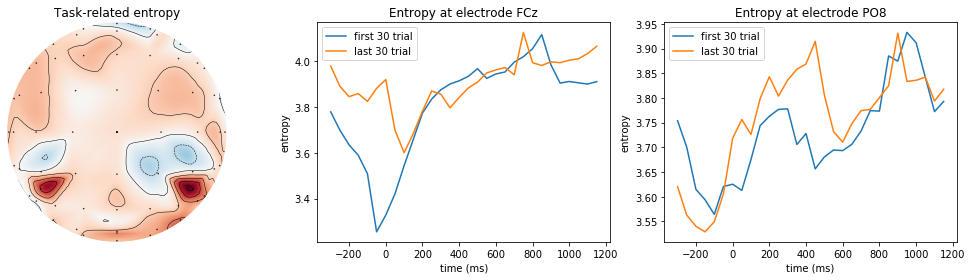

In [7]:
# plot results

# creae figure
fig_29_5, (ax_a,ax_b,ax_c) = plt.subplots(1,3, figsize=[14,4], tight_layout=True)

# plot entropy topomap (29.5 A)
mne.viz.plot_topomap(entropy_topo, coords_2d, axes=ax_a, show=False)
ax_a.set(title='Task-related entropy')

# plot time-course entropy for FCz (29.5 B)
ax_b.plot(time, entropy_fcz[:,0], label='first 30 trial')
ax_b.plot(time, entropy_fcz[:,1], label='last 30 trial')
ax_b.set(xlabel='time (ms)', ylabel='entropy', title='Entropy at electrode FCz')
ax_b.legend()

# plot time-course entropy for PO8 (29.5 C)
ax_c.plot(time, entropy_po8[:,0], label='first 30 trial')
ax_c.plot(time, entropy_po8[:,1], label='last 30 trial')
ax_c.set(xlabel='time (ms)', ylabel='entropy', title='Entropy at electrode PO8')
ax_c.legend()

### Figure 29.6

In [8]:
# define functions

def fd_rule(sig_0, sig_1):
    # determine optimal number of bins for each signal
    n_samples = len(sig_0)
    fd_bins_0 = (np.max(sig_0)-np.min(sig_0)) / \
                (2.0*stats.iqr(sig_0)*n_samples**(-1/3))  

    fd_bins_1 = (np.max(sig_1)-np.min(sig_1)) / \
                (2.0*stats.iqr(sig_1)*n_samples**(-1/3))
    
    # average FD result for 2 signals
    fd_bins = int(np.ceil((fd_bins_0+fd_bins_1)/2))
    
    return fd_bins

def comp_joint_entropy(sig_0, sig_1):
    # determine optimal number of bins
    fd_bins = fd_rule(sig_0, sig_1)
    
    # bin data
    edges_0 = np.linspace(np.min(sig_0), np.max(sig_0), fd_bins+1)
    edges_1 = np.linspace(np.min(sig_1), np.max(sig_1), fd_bins+1)
    hist_0 = np.digitize(sig_0, edges_0) - 1
    hist_1 = np.digitize(sig_1, edges_1) - 1

    # compute joint frequency table
    joint_prob = np.zeros([fd_bins,fd_bins])
    for i_bin in range(fd_bins):
        for j_bin in range(fd_bins):
            joint_prob[i_bin, j_bin] = np.sum((hist_0==i_bin) & (hist_1==j_bin))
    joint_prob += 1E-6
    joint_prob = joint_prob / np.sum(joint_prob)
    
    # compute entropy
    joint_entropy = -np.sum(joint_prob * np.log2(joint_prob+1E-6))
    
    return joint_entropy, joint_prob

In [9]:
# compute joint probability distributions

# sim signals
time = np.linspace(0,1,10000)
# white noise
sig_0 = np.vstack([np.random.rand(len(time))*2-1, np.random.rand(len(time))*2-1])
# sine wave and noisy sine wave (in phase)
sig_1 = np.vstack([np.sin(2*np.pi*10*time), np.sin(2*np.pi*10*time) + (np.random.rand(len(time))/2)])
# 2 pure sine waves (one inverted)
sig_2 = np.vstack([np.sin(2*np.pi*10*time), -np.sin(2*np.pi*10*time)])

# compute joint probability of each signal pari
_, joint_prob_0 = comp_joint_entropy(sig_0[0], sig_0[1])
_, joint_prob_1 = comp_joint_entropy(sig_1[0], sig_1[1])
_, joint_prob_2 = comp_joint_entropy(sig_2[0], sig_2[1])


[Text(0.5, 1.0, 'Joint probability distributions')]

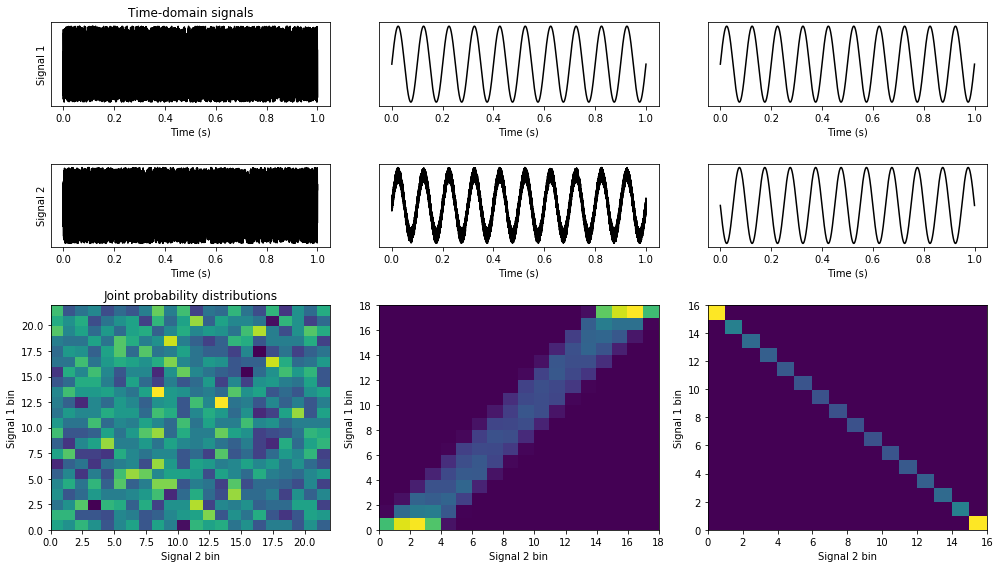

In [10]:
# plot results

# create figure
fig_29_6 = plt.figure(figsize=[14,8], tight_layout=True)
spec = gridspec.GridSpec(ncols=6, nrows=4, figure=fig_29_4)
ax_a1t = fig_29_6.add_subplot(spec[0, 0:2])
ax_a1b = fig_29_6.add_subplot(spec[1, 0:2])
ax_a2t = fig_29_6.add_subplot(spec[0, 2:4])
ax_a2b = fig_29_6.add_subplot(spec[1, 2:4])
ax_a3t = fig_29_6.add_subplot(spec[0, 4:6])
ax_a3b = fig_29_6.add_subplot(spec[1, 4:6])

ax_b1 = fig_29_6.add_subplot(spec[2:4, 0:2])
ax_b2 = fig_29_6.add_subplot(spec[2:4, 2:4])
ax_b3 = fig_29_6.add_subplot(spec[2:4, 4:6])

# plot signals
for sig, ax in zip([sig_0[0], sig_0[1], sig_1[0], sig_1[1], sig_2[0], sig_2[1]], 
                   [ax_a1t, ax_a1b, ax_a2t, ax_a2b, ax_a3t, ax_a3b]):
    ax.plot(time, sig, color='k')
    ax.set(xlabel='Time (s)')
    ax.set_yticks([])
# label A)
ax_a1t.set(ylabel='Signal 1', title='Time-domain signals')
ax_a1b.set(ylabel='Signal 2')

# plot joint prob distr
for joint_prob, ax in zip([joint_prob_0, joint_prob_1, joint_prob_2], 
                   [ax_b1, ax_b2, ax_b3]):
    ax.pcolor(joint_prob)
    ax.set(xlabel='Signal 2 bin', ylabel='Signal 1 bin')
# label B)
ax_b1.set(title='Joint probability distributions')

### FIgure 29.7

In [11]:
# functions

def mutual_information(sig_0, sig_1, n_bins):
    # compute entropy
    entropy_0 = calc_entropy(sig_0, n_bins)
    entropy_1 = calc_entropy(sig_1, n_bins)
    
    # compute joint entropy
    joint_entropy, _ = comp_joint_entropy(sig_0, sig_1)
    
    # compte mutual information
    mi = entropy_0 + entropy_1 - joint_entropy
    
    return mi, entropy_0, entropy_1, joint_entropy

In [12]:
# analysis

# define signals - 29.7 a and b
x_ab = np.linspace(0,1,1000)
y_a = x_ab
y_b = -x_ab**3

# define signals - 29.7 c
x_c = np.cos(np.linspace(0,2*np.pi,100))
y_c = np.sin(np.linspace(0,2*np.pi,100))

# define signals - 29.7 d
x_d = np.concatenate([np.cos(np.linspace(0,2*np.pi,100)), \
                      np.cos(np.linspace(0,2*np.pi,100)) + 1])
y_d = np.concatenate([np.sin(np.linspace(0,2*np.pi,100)), \
                      np.sin(np.linspace(0,2*np.pi,100)) - 1])

# compute mutual information
mi_a,_,_,_ = mutual_information(x_ab, y_a, fd_rule(x_ab, y_a))
mi_b,_,_,_ = mutual_information(x_ab, y_b, fd_rule(x_ab, y_b))
mi_c,_,_,_ = mutual_information(x_c, y_c, fd_rule(x_c, y_c))
mi_d,_,_,_ = mutual_information(x_d, y_d, fd_rule(x_d, y_d))

# compute spearman corr
spearman_a, _ = stats.spearmanr(x_ab, y_a)
spearman_b, _ = stats.spearmanr(x_ab, y_b)
spearman_c, _ = stats.spearmanr(x_c, y_c)
spearman_d, _ = stats.spearmanr(x_d, y_d)

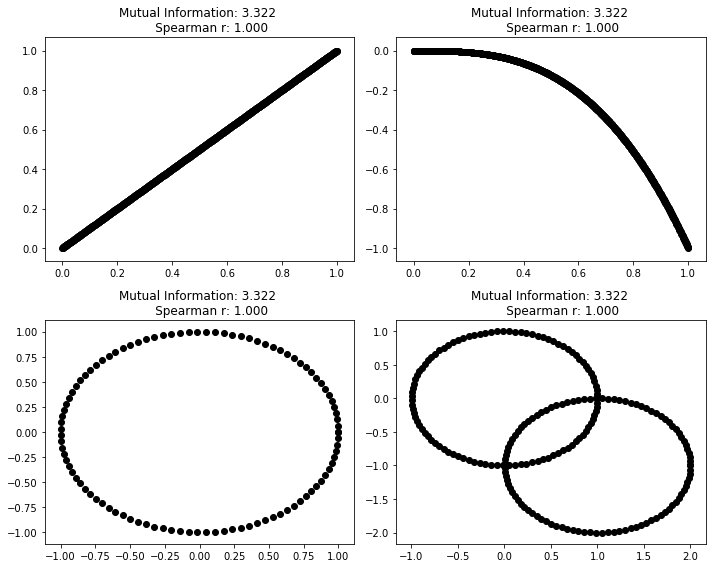

In [13]:
# plot

# create figure
fig_29_7, ((ax_1,ax_2),(ax_3,ax_4)) = plt.subplots(2,2, figsize=[10,8], tight_layout=True)

# 29.7 a
ax_1.scatter(x_ab, y_a, color='k')
ax_1.set_title('Mutual Information: %0.3f \n      Spearman r: %0.3f' %(mi_a, spearman_a))

# 29.7 b
ax_2.scatter(x_ab, y_b, color='k')
ax_2.set_title('Mutual Information: %0.3f \n      Spearman r: %0.3f' %(mi_a, spearman_a))

# 29.7 c
ax_3.scatter(x_c, y_c, color='k')
ax_3.set_title('Mutual Information: %0.3f \n      Spearman r: %0.3f' %(mi_a, spearman_a))

# 29.7 d
ax_4.scatter(x_d, y_d, color='k')
ax_4.set_title('Mutual Information: %0.3f \n      Spearman r: %0.3f' %(mi_a, spearman_a));